In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

np.random.seed(101)

# 1. Stock price simulation  
using the Black & Scholes (B&S) model

In [110]:
# Simulation parameters
T = 10  # Investment horizon (10 years)
N = 10  # Number of steps (annual rebalancing)
M = 120  # Number of simulation steps (monthly)
dt = T / M  # Time interval

time_steps = np.linspace(0, T, N + 1) 

# Black-Scholes parameters for the stock
S0 = 100  # Initial price
mu = 0.07  # Expected return
sigma = 0.2  # Volatility

# Stock price simulation
S_t = [S0]
for _ in range(M):
    dW = np.random.normal(0, np.sqrt(dt))
    S_t.append(S_t[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW))

# 2. Simulation of the price of a zero-coupon bond (ZCB) 
with the Vasicek model for interest rates.

In [111]:
# Vasicek parameters for interest rates
r0 = 0.02  # Initial rate
kappa = 0.1  # Speed of adjustment
theta = 0.03  # Equilibrium level
sigma_r = 0.01  # Volatility

# Simulation of interest rates with the Vasicek model
r_t = [r0]
for _ in range(M):
    dW = np.random.normal(0, np.sqrt(dt))
    r_t.append(r_t[-1] + kappa * (theta - r_t[-1]) * dt + sigma_r * dW)

annual_r_t = [r_t[i] for i in range(1, M+1, M//N)]  

F = 100
# Calcolo del prezzo dello ZCB (maturity 10 anni)
ZCB_t = [F * np.exp(-r_t[0] * T)]
for i in range(1, M + 1):
    ZCB_t.append(F * np.exp(-r_t[i] * (T - i * dt)))

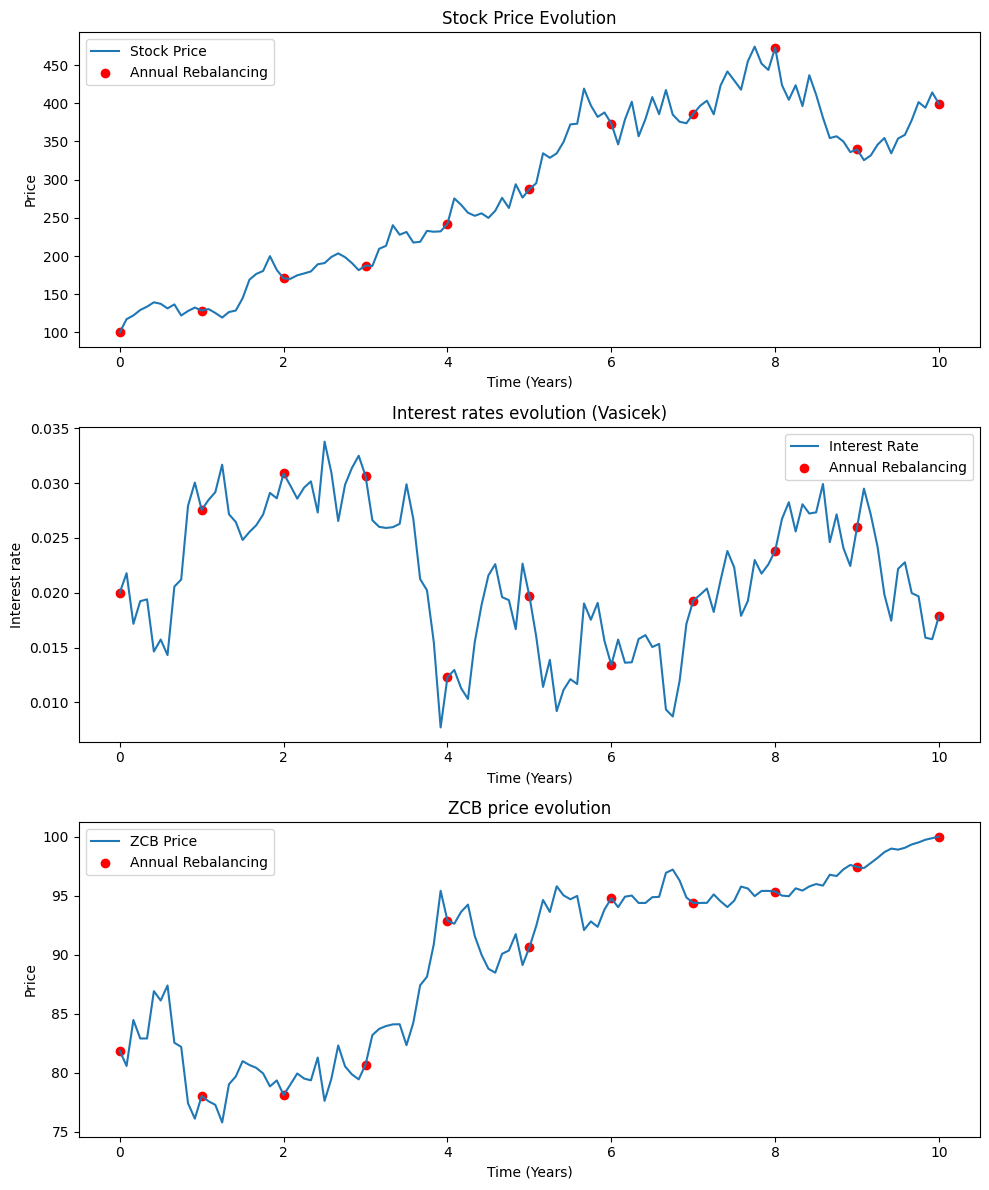

In [112]:
# Selection of annual points for rebalancing
time_annual = np.linspace(0, T, N + 1)
S_annual = S_t[::12]
r_annual = r_t[::12]
ZCB_annual = ZCB_t[::12]

# Plot of results
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].plot(np.linspace(0, T, M + 1), S_t, label='Stock Price')
axes[0].scatter(time_annual, S_annual, color='red', label='Annual Rebalancing')
axes[0].set_title("Stock Price Evolution")
axes[0].set_xlabel("Time (Years)")
axes[0].set_ylabel("Price")
axes[0].legend()

axes[1].plot(np.linspace(0, T, M + 1), r_t, label='Interest Rate')
axes[1].scatter(time_annual, r_annual, color='red', label='Annual Rebalancing')
axes[1].set_title("Interest rates evolution (Vasicek)")
axes[1].set_xlabel("Time (Years)")
axes[1].set_ylabel("Interest rate")
axes[1].legend()

axes[2].plot(np.linspace(0, T, M + 1), ZCB_t, label='ZCB Price')
axes[2].scatter(time_annual, ZCB_annual, color='red', label='Annual Rebalancing')
axes[2].set_title("ZCB price evolution")
axes[2].set_xlabel("Time (Years)")
axes[2].set_ylabel("Price")
axes[2].legend()

plt.tight_layout()
plt.show()

# 3. Model Points Evolution

In [113]:
class InsurancePolicyModel:
    def __init__(self, initial_policies, lapse_base_rate, new_business_base_rate, guaranteed_rates, participation_rates, mortality_rates, value_contracts=1000,  annual_rt=annual_r_t):
        self.policies = np.array(initial_policies, dtype=float)  
        self.lapse_base_rate = lapse_base_rate  
        self.new_business_base_rate = new_business_base_rate  
        self.guaranteed_rates = np.array(guaranteed_rates, dtype=float)  
        self.participation_rates = np.array(participation_rates, dtype=float)  
        self.mortality_rates = np.array(mortality_rates, dtype=float)  
        self.value_contracts = value_contracts  
        self.annual_rt = np.array(annual_rt)
        self.lapse_rates = np.full_like(self.policies, lapse_base_rate, dtype=float)  
        self.new_business_rates = np.full_like(self.policies, new_business_base_rate, dtype=float) 
        self.policy_evolution = []  
        self.durations = []
        
    
    def update_lapse_rate(self, benchmark_return, portfolio_return):
        max_internal_return = self.guaranteed_rates
        delta_r_s = np.maximum(0, benchmark_return - max_internal_return)  
        self.lapse_rates = self.lapse_base_rate * np.exp(5 * delta_r_s)  
    
    def update_new_business_rate(self, benchmark_return, portfolio_return):
        max_internal_return = self.guaranteed_rates
        delta_r_n = np.maximum(0, max_internal_return - benchmark_return)  
        self.new_business_rates = self.new_business_base_rate * np.exp(5 * delta_r_n)  
    
    def simulate_lapse(self):
        lapse_events = np.random.binomial(self.policies.astype(int), self.lapse_rates)  
        self.policies -= lapse_events  
        return lapse_events
    
    def simulate_mortality(self):
        mortality_events = np.random.binomial(self.policies.astype(int), self.mortality_rates)  
        self.policies -= mortality_events  
        return mortality_events
    
    def simulate_new_business(self):
        total_new_contracts = np.random.binomial(1000, np.mean(self.new_business_rates))  
        age_distribution_weights = np.array([0.35, 0.25, 0.2, 0.1, 0.07, 0.03])  
        age_distribution_weights /= age_distribution_weights.sum()  
        new_business_events = np.random.multinomial(total_new_contracts, age_distribution_weights)  
        self.policies += new_business_events  
        return new_business_events

    def calculate_duration(self, years):
        total_present_value = 0
        weighted_sum = 0
        for t in range(1, years + 1):
            discount_factor = (1 + self.annual_rt[t-1]) ** -t  
            cashflow = self.policies.sum() * self.value_contracts 
            pv_cashflow = cashflow * discount_factor 
            total_present_value += pv_cashflow
            weighted_sum += t * pv_cashflow 

        duration = weighted_sum / total_present_value if total_present_value > 0 else 0
        self.durations.append(duration) 
        return duration
    
    def calculate_present_value_liabilities(self, years):
        present_value_liabilities = []
        for t in range(years):
            total_pv_liability = 0
            for future_t in range(1, years - t + 1): 
                discount_factor = (1 + self.annual_rt[t + future_t - 1]) ** -future_t  
                expected_cashflow = self.policies.sum() * self.value_contracts  
                total_pv_liability += expected_cashflow * discount_factor  
            present_value_liabilities.append(total_pv_liability)
        
        return present_value_liabilities

    def simulate_policy_evolution(self, years, benchmark_returns, portfolio_returns):
        self.policy_evolution = [self.policies.copy()]  
        self.durations = []
        annual_cashflows = []  

        for t in range(years):
            self.update_lapse_rate(benchmark_returns[t], portfolio_returns[t])  
            self.update_new_business_rate(benchmark_returns[t], portfolio_returns[t])  
            lapse_events = self.simulate_lapse()  
            mortality_events = self.simulate_mortality()  
            self.simulate_new_business()  
            self.policy_evolution.append(self.policies.copy())  
            total_cashflow = lapse_events.sum() * self.value_contracts + mortality_events.sum() * self.value_contracts
            annual_cashflows.append(total_cashflow)
            duration = self.calculate_duration(years - t)
            present_value_liabilities = self.calculate_present_value_liabilities(years)

        
        self.policy_evolution = np.array(self.policy_evolution)  

        plt.figure(figsize=(10, 5))
        for i in range(self.policy_evolution.shape[1]):
            plt.plot(range(years + 1), self.policy_evolution[:, i], label=f"Age Group {i+1}")
        plt.xlabel("Years")
        plt.ylabel("Active Policies")
        plt.title("Policy Evolution with Lapses and New Contracts")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.plot(range(years), annual_cashflows, label="Required Liquidity")
        plt.xlabel("Years")
        plt.ylabel("Required Liquidity (€)")
        plt.title("Annual Liquidity for Lapse and Mortality Payments")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(range(years), self.durations, label="Liability Duration", color='r')
        plt.xlabel("Years")
        plt.ylabel("Duration (Years)")
        plt.title("Evolution of Liability Duration")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(range(years), present_value_liabilities, label="Valore presente delle liabilities", color='g')
        plt.xlabel("Years")
        plt.ylabel("Present Value (€)")
        plt.title("Evolution of Present Value of Liabilities")
        plt.legend()
        plt.show()

    
        return self.policy_evolution, annual_cashflows, self.durations, present_value_liabilities

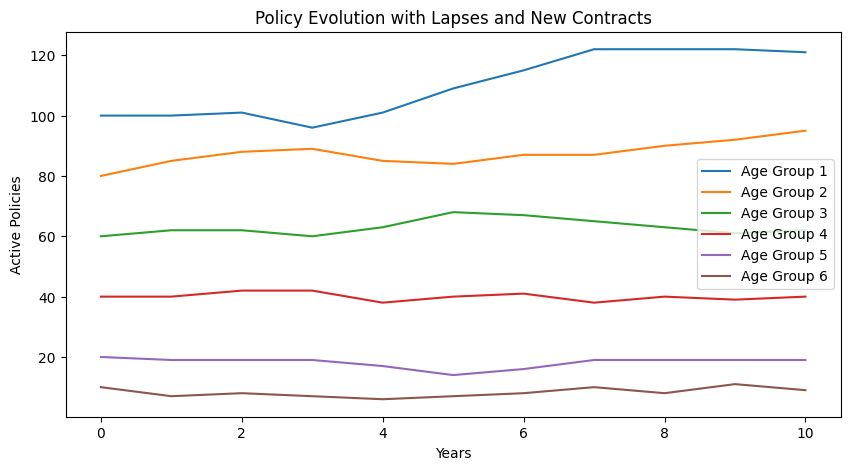

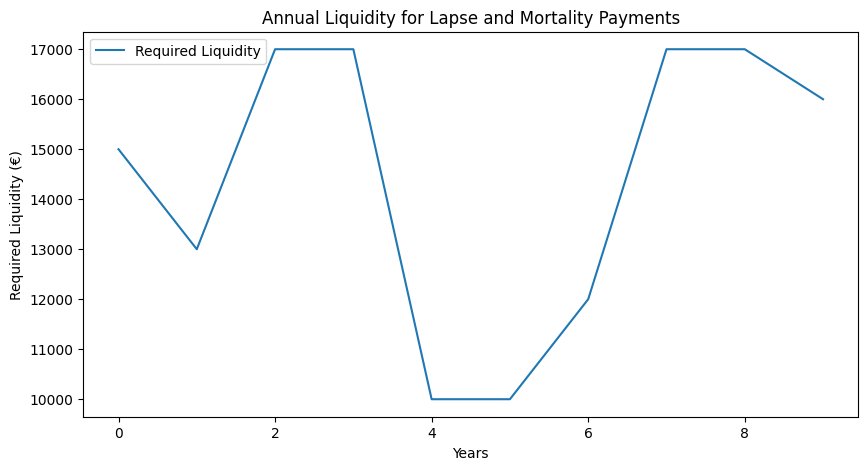

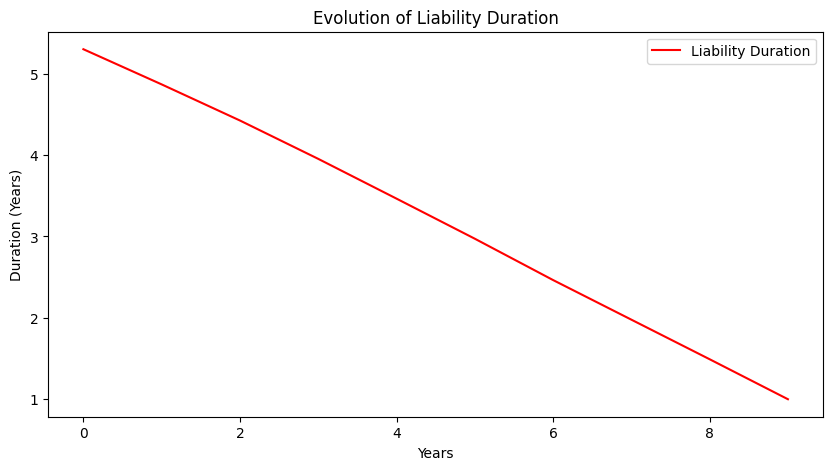

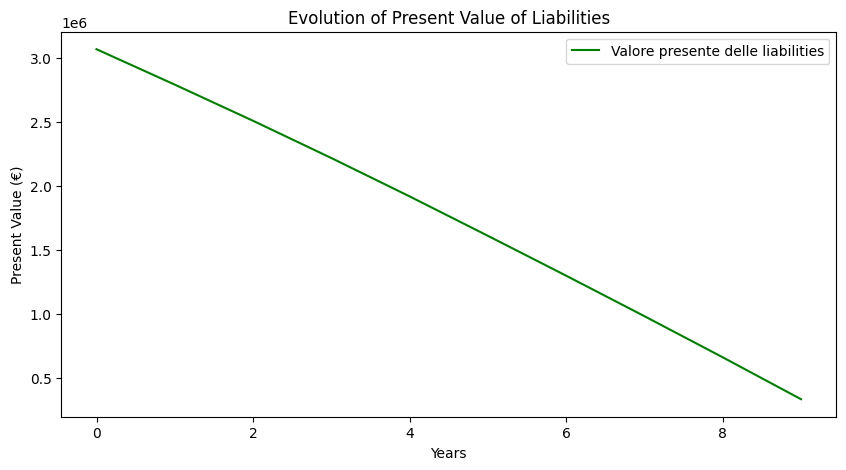

Evoluzione delle polizze:
 [[100.  80.  60.  40.  20.  10.]
 [100.  85.  62.  40.  19.   7.]
 [101.  88.  62.  42.  19.   8.]
 [ 96.  89.  60.  42.  19.   7.]
 [101.  85.  63.  38.  17.   6.]
 [109.  84.  68.  40.  14.   7.]
 [115.  87.  67.  41.  16.   8.]
 [122.  87.  65.  38.  19.  10.]
 [122.  90.  63.  40.  19.   8.]
 [122.  92.  61.  39.  19.  11.]
 [121.  95.  62.  40.  19.   9.]]
Liquidità necessaria annuale: [np.int64(15000), np.int64(13000), np.int64(17000), np.int64(17000), np.int64(10000), np.int64(10000), np.int64(12000), np.int64(17000), np.int64(17000), np.int64(16000)]
Duration delle liabilities nel tempo: [np.float64(5.301631276787732), np.float64(4.8693209127697905), np.float64(4.425418460863934), np.float64(3.954158186171687), np.float64(3.4653998700875714), np.float64(2.9728096804396094), np.float64(2.4645907630968344), np.float64(1.9778493371254973), np.float64(1.4913564918243822), np.float64(1.0)]


In [114]:
initial_policies = [100, 80, 60, 40, 20, 10]  
lapse_base_rate = 0.03  
new_business_base_rate = 0.02  
guaranteed_rates = [0.0, 0.01, 0.012, 0.015, 0.017, 0.02]  
participation_rates = [0.0, 0.01, 0.012, 0.015, 0.017, 0.02]  
mortality_rates = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]  

years = 10
benchmark_returns = annual_r_t  

policy_model = InsurancePolicyModel(initial_policies, lapse_base_rate, new_business_base_rate, guaranteed_rates, participation_rates, mortality_rates, annual_rt=annual_r_t)
policy_evolution, annual_cashflows, durations, present_value_liabilities = policy_model.simulate_policy_evolution(years, benchmark_returns, benchmark_returns)

print("Evoluzione delle polizze:\n", policy_evolution)
print("Liquidità necessaria annuale:", annual_cashflows)
print("Duration delle liabilities nel tempo:", durations)

# 4. Rebalancing

In [115]:
class Portfolio:
    def __init__(self, initial_cash, x_s, x_b, x_c):
        self.cash = initial_cash * x_c # Initial liquidity
        self.x_s = x_s  # Target allocation in stocks
        self.x_b = x_b  # Target allocation in bonds
        self.x_c = x_c  # Target allocation in cash
        self.PMV_S = 0
        self.PMV_B = 0
        self.CR_t = 0
        self.CR_t_1 = 0
        self.RF = 0
        self.sell_or_buy_S = " "
        self.sell_or_buy_B = " "
        
        # Initial market values
        self.VM_S = initial_cash * x_s  # Market Value stocks
        self.VM_B = initial_cash * x_b  # Market Value bonds
        self.VM_P = self.VM_S + self.VM_B + self.cash # Total portfolio Market Value
        
        # Initial account values
        self.VC_S = self.VM_S  # Account Value stocks
        self.VC_B = self.VM_B  # Account Value bonds
    
    def rebalance(self, new_VM_S, new_VM_B):
        """ Performs portfolio rebalancing. """
        self.VM_S = new_VM_S
        self.VM_B = new_VM_B
        self.VM_P = self.VM_S + self.VM_B + self.cash
        self.CR_t_1 = self.CR_t
        self.PMV_S = 0
        self.PMV_B = 0
        self.RF = 0
        self.sell_or_buy_S = " "
        self.sell_or_buy_B = " "
        
        # Check if stocks are overweight
        self.target_VM_S = self.x_s * self.VM_P
        if self.VM_S >= self.target_VM_S:
            self.delta_S = self.VM_S - self.target_VM_S # Excess stock value that needs to be sold
            self.sell_or_buy_S = "Sell Stocks"
            self.PMV_S = self.delta_S - self.VC_S * (self.delta_S / self.VM_S) # Amount withdrawn from the account associated with stocks.
            self.VC_S *= (1 - self.delta_S / self.VM_S)
            self.VM_S = self.target_VM_S
        elif self.VM_S < self.target_VM_S:
            self.delta_S = self.target_VM_S - self.VM_S # Missing stock value that needs to be purchased.
            self.sell_or_buy_S = "Buy Stocks"
            self.VC_S += self.delta_S
            self.VM_S = self.target_VM_S
        
        # Check if bonds are overweight
        self.target_VM_B = self.x_b * self.VM_P
        if self.VM_B >= self.target_VM_B:
            self.delta_B = self.VM_B - self.target_VM_B # Excess bond value that needs to be sold
            self.sell_or_buy_B = "Sell Bonds"
            self.PMV_B = self.delta_B - self.VC_B * (self.delta_B / self.VM_B)   # Amount withdrawn from the account associated with bonds
            self.CR_t = max(0, self.CR_t + self.PMV_B)  # Amount of bonds sold set aside in the Capitalization Reserve
            self.VC_B *= (1 - self.delta_B / self.VM_B)
            self.VM_B = self.target_VM_B
        elif self.VM_B < self.target_VM_B:
            self.delta_B = self.target_VM_B - self.VM_B # Bond value variation
            self.sell_or_buy_B = "Buy Bonds"
            self.VC_B += self.delta_B
            self.VM_B = self.target_VM_B
        
        self.RF = self.PMV_S + (self.CR_t_1 + self.PMV_B) * (self.CR_t_1 + self.PMV_B <= 0)
        
    def __str__(self):
        return (f"Updated Portfolio:\n"
                f"Market Value Stocks: {self.VM_S:.2f}\n"
                f"Target Value Stocks: {self.target_VM_S:.2f}\n"
                f"Delta Stocks: {self.delta_S:.2f}\n"
                f"Operation: {self.sell_or_buy_S:.2f}\n"
                f"Market Value Bonds: {self.VM_B:.2f}\n"
                f"Target Value Bonds: {self.target_VM_B:.2f}\n"
                f"Delta Bonds: {self.delta_B:.2f}\n"
                f"Operation: {self.sell_or_buy_B:.2f}\n"
                f"Account Value Stocks: {self.VC_S:.2f}\n"
                f"Account Value Bonds: {self.VC_B:.2f}\n"
                f"Plus-Minus Value Stocks: {self.PMV_S:.2f}\n"
                f"Plus-Minus Value Bonds: {self.PMV_B:.2f}\n"
                f"Capitalization Reserve: {self.CR_t:.2f}\n"
                f"Financial Income: {self.RF:.2f}\n")

# 5. Simulation of the portfolio rebalancing strategy
every year for 10 years.

In [116]:
# Portfolio creation
initial_cash = 10_000_000
portfolio = Portfolio(initial_cash=initial_cash, x_s=0.2, x_b=0.7, x_c=0.1)

# Lists to store simulation data
years = [0]  # Starts from year 0
market_values_S = [portfolio.VM_S]
target_VM_S_values = [" "]
delta_S_values = [" "]
operation_S = [" "]
market_values_B = [portfolio.VM_B]
target_VM_B_values = [" "]
delta_B_values = [" "]
operation_B = [" "]
account_values_S = [" "]
account_values_B = [" "]
pmv_S_values = [" "]
pmv_B_values = [" "]
cap_reserve_values = [" "]
financial_income_values = [" "]
l_d_values = [" "]
adj_financial_income_values = [" "]

# Rebalancing simulation
for i in range(1, N + 1):
    new_VM_S = (portfolio.VM_S / S_t[i - 1]) * S_t[i]  # Stock update
    new_VM_B = (portfolio.VM_B / (ZCB_t[i - 1] / F)) * (ZCB_t[i] / F)  # Bond update
    portfolio.rebalance(new_VM_S, new_VM_B)

    # Store values
    years.append(i)
    market_values_S.append(portfolio.VM_S)
    target_VM_S_values.append(portfolio.target_VM_S)
    delta_S_values.append(portfolio.delta_S)
    operation_S.append(portfolio.sell_or_buy_S)
    market_values_B.append(portfolio.VM_B)
    target_VM_B_values.append(portfolio.target_VM_B)
    delta_B_values.append(portfolio.delta_B)
    operation_B.append(portfolio.sell_or_buy_B)
    account_values_S.append(portfolio.VC_S)
    account_values_B.append(portfolio.VC_B)
    pmv_S_values.append(portfolio.PMV_S)
    pmv_B_values.append(portfolio.PMV_B)
    cap_reserve_values.append(portfolio.CR_t)
    financial_income_values.append(portfolio.RF)
    l_d_values.append(annual_cashflows[i-1])
    adj_financial_income_values.append(portfolio.RF - annual_cashflows[i-1])


pd.options.display.float_format = '{:.2f}'.format

# Create the table 
df = pd.DataFrame({
    "Year": years,
    "Market Value Stocks": market_values_S,
    "Target Value Stocks": target_VM_S_values,
    "Delta Stocks": delta_S_values,
    "Operation Stocks": operation_S,
    "Market Value Bonds": market_values_B,
    "Target Value Bonds": target_VM_B_values,
    "Delta Bonds": delta_B_values,
    "Operation Bonds": operation_B,
    "Account Value Stocks": account_values_S,
    "Account Value Bonds": account_values_B,
    "Plus-Minus Value Stocks": pmv_S_values,
    "Plus-Minus Value Bonds": pmv_B_values,
    "Capitalization Reserve": cap_reserve_values,
    "Financial Income": financial_income_values,
    "Total Claims": l_d_values,
    "Adjusted Financial Income": adj_financial_income_values
})

# Print the table
df.head(11)

,Year,Market Value Stocks,Target Value Stocks,Delta Stocks,Operation Stocks,Market Value Bonds,Target Value Bonds,Delta Bonds,Operation Bonds,Account Value Stocks,Account Value Bonds,Plus-Minus Value Stocks,Plus-Minus Value Bonds,Capitalization Reserve,Financial Income,Total Claims,Adjusted Financial Income
0,0,2000000.00,,,,7000000.00,,,,,,,,,,,
1,1,2047448.31,2047448.31,300622.11,Sell Stocks,7166069.09,7166069.09,276897.96,Buy Bonds,1743941.14,7276897.96,44563.26,0,0,44563.26,15000,29563.26
2,2,2128816.51,2128816.51,3110.39,Sell Stocks,7450857.77,7450857.77,61297.86,Sell Bonds,1741396.81,7217519.76,566.06,1919.66,1919.66,566.06,13000,-12433.94
3,3,2113141.68,2113141.68,139614.65,Sell Stocks,7395995.89,7395995.89,83043.80,Buy Bonds,1633473.68,7300563.56,31691.52,0,1919.66,31691.52,17000,14691.52
4,4,2116127.47,2116127.47,68468.39,Sell Stocks,7406446.13,7406446.13,10404.66,Buy Bonds,1582278.26,7310968.22,17272.97,0,1919.66,17272.97,17000,272.97
5,5,2194152.89,2194152.89,12212.92,Sell Stocks,7679535.10,7679535.10,84863.52,Sell Bonds,1573519.86,7231060.61,3454.52,4955.92,6875.58,3454.52,10000,-6545.48
6,6,2154522.64,2154522.64,8543.82,Sell Stocks,7540829.25,7540829.25,68717.50,Sell Bonds,1567304.66,7165761.01,2328.63,3417.89,10293.47,2328.63,10000,-7671.37
7,7,2142473.86,2142473.86,82337.64,Buy Stocks,7498658.51,7498658.51,153574.57,Sell Bonds,1649642.31,7021949.56,0,9763.13,20056.60,0.00,12000,-12000.00
8,8,2062120.36,2062120.36,165899.56,Sell Stocks,7217421.25,7217421.25,134839.39,Buy Bonds,1526809.05,7156788.95,43066.31,0,20056.60,43066.31,17000,26066.31
9,9,2005901.17,2005901.17,162923.76,Buy Stocks,7020654.11,7020654.11,165874.35,Sell Bonds,1689732.81,6991601.03,0,686.43,20743.03,0.00,17000,-17000.00


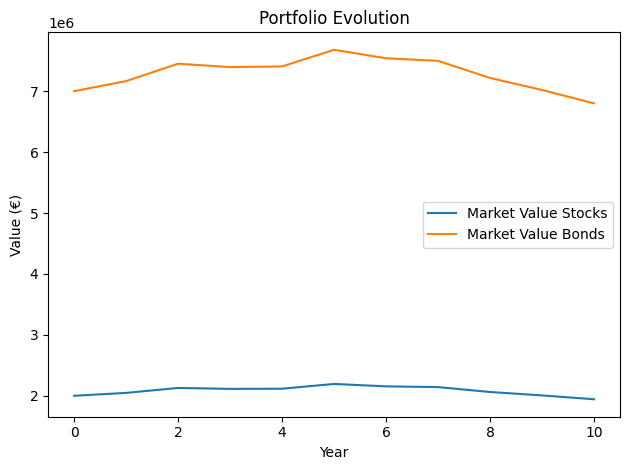

In [117]:
fig = plt.figure()

plt.plot(years, market_values_S, label="Market Value Stocks")
plt.plot(years, market_values_B, label="Market Value Bonds")
plt.xlabel("Year")
plt.ylabel("Value (€)")
plt.title("Portfolio Evolution")
plt.legend()

plt.tight_layout() 
plt.show()

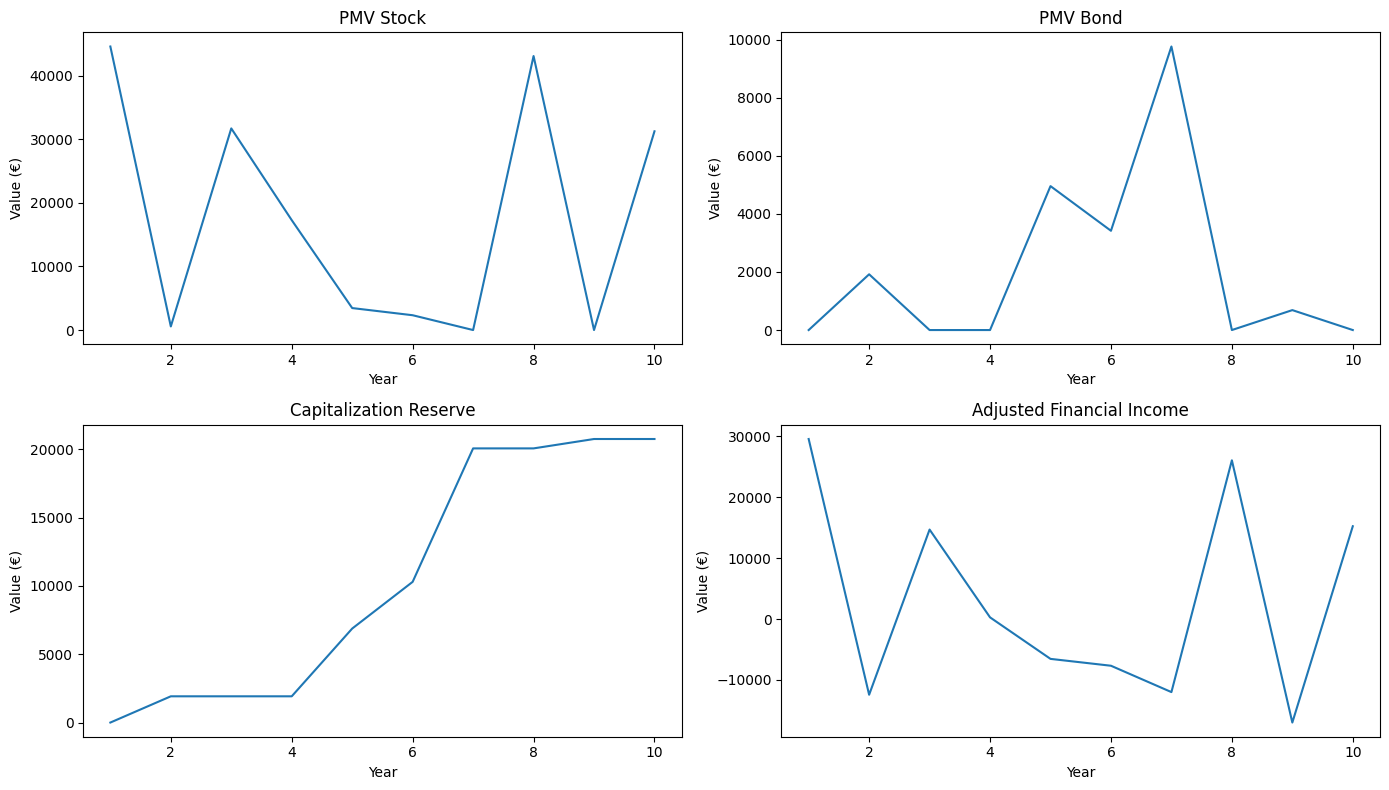

In [118]:
pmv_S_values = pmv_S_values[1:N+1]  
pmv_B_values = pmv_B_values[1:N+1]
cap_reserve_values = cap_reserve_values[1:N+1]
adj_financial_income_values = adj_financial_income_values[1:N+1]

fig, axes = plt.subplots(2, 2, figsize=(14, 8)) 

axes[0, 0].plot(range(1, N + 1), pmv_S_values)
axes[0, 0].set_title("PMV Stock")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Value (€)")

axes[0, 1].plot(range(1, N + 1), pmv_B_values)
axes[0, 1].set_title("PMV Bond")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Value (€)")

axes[1, 0].plot(range(1, N + 1), cap_reserve_values)
axes[1, 0].set_title("Capitalization Reserve")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Value (€)")

axes[1, 1].plot(range(1, N + 1), adj_financial_income_values)
axes[1, 1].set_title("Adjusted Financial Income")
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Value (€)")

plt.tight_layout()  
plt.show()  

In [119]:
def create_annual_cashflow_df(annual_cashflows):
    df_cashflows = pd.DataFrame(annual_cashflows, columns=['Annual Cashflow'])
    df_cashflows['Year'] = df_cashflows.index + 1  
    df_cashflows.set_index('Year', inplace=True)
    return df_cashflows

df_cashflows = create_annual_cashflow_df(annual_cashflows)

print(df_cashflows)


      Annual Cashflow
Year                 
1               15000
2               13000
3               17000
4               17000
5               10000
6               10000
7               12000
8               17000
9               17000
10              16000


In [120]:
age_brackets = [30 + 10 * i for i in range(len(policy_model.guaranteed_rates))]

column_labels = [f"{rate:.2%} - {age} years" for rate, age in zip(policy_model.guaranteed_rates, age_brackets)]

df_policy_evolution = pd.DataFrame(policy_model.policy_evolution, columns=column_labels)

df_policy_evolution.index.name = "Year"

print(df_policy_evolution)

      0.00% - 30 years  1.00% - 40 years  1.20% - 50 years  1.50% - 60 years  \
Year                                                                           
0               100.00             80.00             60.00             40.00   
1               100.00             85.00             62.00             40.00   
2               101.00             88.00             62.00             42.00   
3                96.00             89.00             60.00             42.00   
4               101.00             85.00             63.00             38.00   
5               109.00             84.00             68.00             40.00   
6               115.00             87.00             67.00             41.00   
7               122.00             87.00             65.00             38.00   
8               122.00             90.00             63.00             40.00   
9               122.00             92.00             61.00             39.00   
10              121.00             95.00

In [121]:
latex_code = df_policy_evolution.head(11).to_latex(
    index=True,  
    column_format="|c" * (len(df_policy_evolution.columns) + 1) + "|",  
    float_format="%.2f",  
    caption="Evolution of policies over time",
    label="tab:policy_evolution"  
)

print(latex_code)


\begin{table}
\caption{Evolution of policies over time}
\label{tab:policy_evolution}
\begin{tabular}{|c|c|c|c|c|c|c|}
\toprule
 & 0.00% - 30 years & 1.00% - 40 years & 1.20% - 50 years & 1.50% - 60 years & 1.70% - 70 years & 2.00% - 80 years \\
Year &  &  &  &  &  &  \\
\midrule
0 & 100.00 & 80.00 & 60.00 & 40.00 & 20.00 & 10.00 \\
1 & 100.00 & 85.00 & 62.00 & 40.00 & 19.00 & 7.00 \\
2 & 101.00 & 88.00 & 62.00 & 42.00 & 19.00 & 8.00 \\
3 & 96.00 & 89.00 & 60.00 & 42.00 & 19.00 & 7.00 \\
4 & 101.00 & 85.00 & 63.00 & 38.00 & 17.00 & 6.00 \\
5 & 109.00 & 84.00 & 68.00 & 40.00 & 14.00 & 7.00 \\
6 & 115.00 & 87.00 & 67.00 & 41.00 & 16.00 & 8.00 \\
7 & 122.00 & 87.00 & 65.00 & 38.00 & 19.00 & 10.00 \\
8 & 122.00 & 90.00 & 63.00 & 40.00 & 19.00 & 8.00 \\
9 & 122.00 & 92.00 & 61.00 & 39.00 & 19.00 & 11.00 \\
10 & 121.00 & 95.00 & 62.00 & 40.00 & 19.00 & 9.00 \\
\bottomrule
\end{tabular}
\end{table}

